#102 Flowers Classification
This Project is done using Google Colaboratory.
1st you have to mount google drive with Colab and place dataset in zipped format on Google drive to access it.
This dataset contains flower images of 102 categories. Training images are 6552, validation images are 818 and test images are 819.
I have achieved top1 accuracy 95.73% and top5 accuracy 99.63% on test set. This project is done using a ResNet18(pretrained on imagenet). 

Next cell is for installation of PyTorch on Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!tar -zxvf drive/My\ Drive/flower_data.tar.gz # this line copies the flowers dataset from Google drive to Google Colab and also Unzip it for further processing. 

Mounted at /content/drive
train/
train/101/
train/101/image_07994.jpg
train/101/image_07960.jpg
train/101/image_07947.jpg
train/101/image_07993.jpg
train/101/image_07945.jpg
train/101/image_07973.jpg
train/101/image_07972.jpg
train/101/image_07991.jpg
train/101/image_07977.jpg
train/101/image_07982.jpg
train/101/image_07948.jpg
train/101/image_07969.jpg
train/101/image_07966.jpg
train/101/image_07957.jpg
train/101/image_07979.jpg
train/101/image_07989.jpg
train/101/image_07974.jpg
train/101/image_07961.jpg
train/101/image_07956.jpg
train/101/image_07998.jpg
train/101/image_07990.jpg
train/101/image_07968.jpg
train/101/image_07986.jpg
train/101/image_07967.jpg
train/101/image_07955.jpg
train/101/image_07978.jpg
train/101/image_07944.jpg
train/101/image_07995.jpg
train/101/image_07958.jpg
train/101/image_07981.jpg
train/101/image_07959.jpg
train/101/image_07943.jpg
train/101/image_07980.jpg
train/101/image_07987.jpg
train/101/image_07954.jpg
train/101/image_07965.jpg
train/101/image_0796

In [0]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
import torch.utils.data as data
from torchvision import datasets, models, transforms
import time
import json
import copy
import seaborn as sns
import numpy as np
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt

#Load Data
We will use torchvision and torch.utils.data packages for loading the data.
For the training, i have applied transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I also made it sure that the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this i have not performed any scaling or rotation transformations, but i had resized and then cropped the images to the appropriate size.

The pre-trained networki have used was trained on the ImageNet dataset where each color channel was normalized separately. For all three sets i have normalized the means and standard deviations of the images to what the network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
data_dir = '.'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
# TODO: Define your transforms for the training, validation, and testing sets
# defining data transforms for training, validation and test data and also normalizing whole data
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.Resize(195),
            #transforms.RandomRotation(45),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.Resize(195),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.Resize(195),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

# TODO: Load the datasets with ImageFolder
# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

# TODO: Using the image datasets and the trainforms, define the dataloaders
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
        for x in list(image_datasets.keys())
    }
dataset_sizes = {
        x: len(dataloaders[x].dataset) 
        for x in list(image_datasets.keys())
    } 
class_names = image_datasets['train'].classes

In [5]:
dataset_sizes # printing dataset's sizes for training, validation and testing

{'test': 819, 'train': 6552, 'valid': 818}

#Label mapping
I had load in a mapping from category label to category name. I got this in the file cat_to_name.json. It's a JSON object which i have read in with the json module. This gave a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
import json

with open('drive/My Drive/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
# changing categories to their actual names 
for i in range(0,len(class_names)):
    class_names[i] = cat_to_name.get(class_names[i])

#Visualize a few images
Let's visualize a few training images so as to understand the data augmentations.

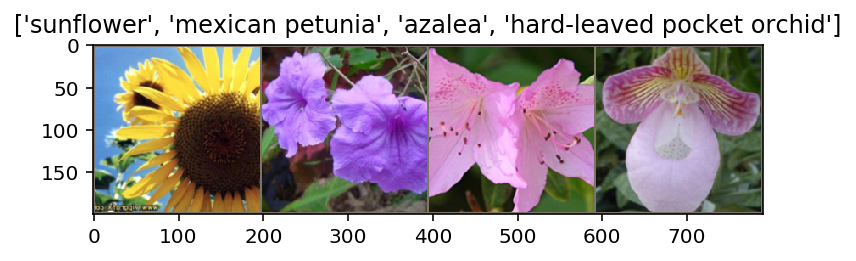

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
import sys
sys.path.append('/content/drive/My Drive/efficientnet-pytorch-master')
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/My Drive/efficientnet-pytorch-master']

#Finetuning the convnet
Load a pretrained Resnet 18 model and reset final fully connected layer.

 


In [10]:
!pip install mlconfig
from efficientnet.models.efficientnet import EfficientNet, params


def numel(model):
    return sum(p.numel() for p in model.parameters())


def test_output(model, size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    model.eval()

    x = torch.randn(1, 3, size, size).to(device)
    with torch.no_grad():
        y = model(x)
        print('output size: ', y.size(1))


def print_num_parameters(model):
    num_params = numel(model)
    print(f'Number of parameters: {num_params}')


for arch, (w, d, s, r) in params.items():
    model = EfficientNet(w, d, r)

    print(f'Arch: {arch}, settings: {(w, d, s, r)}')
    test_output(model, s)
    print_num_parameters(model)

model_ft = EfficientNet(width_mult=0.9, depth_mult=0.8, dropout_rate=0.2, num_classes=102)
test_output(model_ft, 195)
print_num_parameters(model_ft)
#model_ft = models.resnet18(pretrained=True) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 102) # changing the last layer for this dataset by setting last layer neurons to 102 as this dataset has 102 categories

Arch: efficientnet_b0, settings: (1.0, 1.0, 224, 0.2)
output size:  1000
Number of parameters: 5288548
Arch: efficientnet_b1, settings: (1.0, 1.1, 240, 0.2)
output size:  1000
Number of parameters: 7794184
Arch: efficientnet_b2, settings: (1.1, 1.2, 260, 0.3)
output size:  1000
Number of parameters: 9109994
Arch: efficientnet_b3, settings: (1.2, 1.4, 300, 0.3)
output size:  1000
Number of parameters: 12233232
Arch: efficientnet_b4, settings: (1.4, 1.8, 380, 0.4)
output size:  1000
Number of parameters: 19341616
Arch: efficientnet_b5, settings: (1.6, 2.2, 456, 0.4)
output size:  1000
Number of parameters: 30389784
Arch: efficientnet_b6, settings: (1.8, 2.6, 528, 0.5)
output size:  1000
Number of parameters: 43040704
Arch: efficientnet_b7, settings: (0.9, 0.8, 195, 0.2)
output size:  1000
Number of parameters: 4537832
output size:  102
Number of parameters: 3502438


[링크 텍스트](https://)You can load a checkpoint from your my drive or any other place if you have saved it. you have to load weights of model and optimizer

In [0]:
#checkpoint = torch.load('point_efficientnet_best.pth')
#model_ft.load_state_dict(checkpoint['model'])
#optimizer_ft.load_state_dict(checkpoint['optim'])

In [0]:
use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function


optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

#Training the model
Now, let's write a general function to train a model.
I also have written code to save the best checkpoint within Google drive for using next time

In [0]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data, dtype=torch.float)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                # saving a checkpoint to use for next time to save time used in training from scratch
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state, 'point_efficientnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#Visualizing the model predictions
Generic function to display predictions for a few images

In [0]:
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()
    

    for i, data in enumerate(dataloaders['valid']):
        inputs, labels = data
        #print(labels)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

#Train and evaluate

In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.0974 Acc: 0.0472
valid Loss: 14.6975 Acc: 0.0281

Epoch 1/19
----------
train Loss: 1.0080 Acc: 0.0728
valid Loss: 6.2688 Acc: 0.0831

Epoch 2/19
----------
train Loss: 0.9431 Acc: 0.1067
valid Loss: 2.8630 Acc: 0.1064

Epoch 3/19
----------
train Loss: 0.8780 Acc: 0.1538
valid Loss: 1.5115 Acc: 0.1663

Epoch 4/19
----------
train Loss: 0.8246 Acc: 0.1899
valid Loss: 1.6035 Acc: 0.1846

Epoch 5/19
----------
train Loss: 0.7649 Acc: 0.2463
valid Loss: 0.7077 Acc: 0.3680

Epoch 6/19
----------
train Loss: 0.7097 Acc: 0.2814
valid Loss: 0.6968 Acc: 0.3875

Epoch 7/19
----------
train Loss: 0.6528 Acc: 0.3391
valid Loss: 0.5815 Acc: 0.4156

Epoch 8/19
----------
train Loss: 0.6088 Acc: 0.3730
valid Loss: 0.5803 Acc: 0.4768

Epoch 9/19
----------
train Loss: 0.5630 Acc: 0.4147
valid Loss: 0.4610 Acc: 0.5428

Epoch 10/19
----------
train Loss: 0.5314 Acc: 0.4498
valid Loss: 0.4392 Acc: 0.5550

Epoch 11/19
----------
train Loss: 0.4882 Acc: 0.4852
valid Los

# Checking Model's Predictions

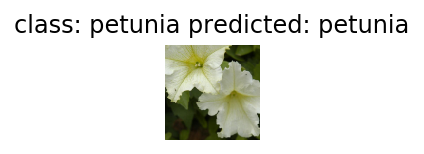

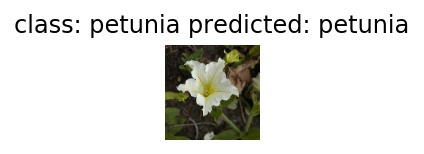

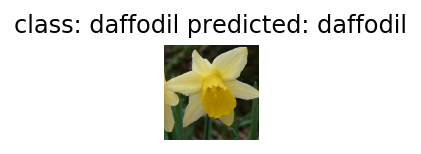

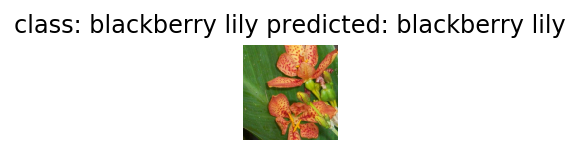

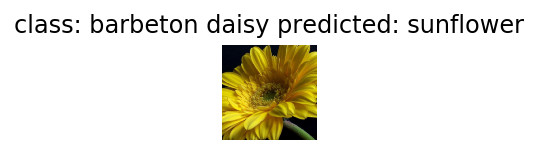

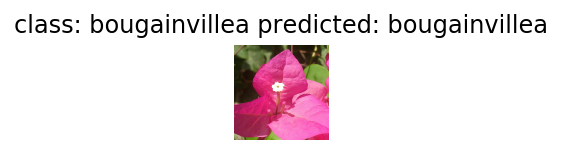

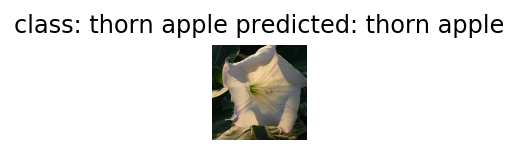

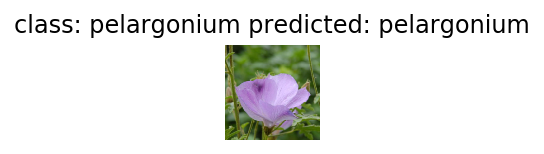

In [16]:
visualize_model(model_ft)

#Checking model's accuracy on test set(This is top-1 accuracy)

In [17]:
def calc_accuracy(model, data):
    model.eval()
    if use_gpu:
      model.cuda()    
    running_corrects = 0
    test_acc = 0
    
    #with torch.no_grad():
    for idx, (inputs, labels) in enumerate(dataloaders[data]):
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        # max provides the (maximum probability, max value)
        #_, predicted = outputs.max(dim=1)
        _, predicted = torch.max(outputs.data, 1)
        running_corrects += torch.sum(predicted == labels, dtype=torch.float)
    test_acc = running_corrects / dataset_sizes['test']
    print('Test Accuracy: {:.4f}'.format(test_acc))
    '''# check the 
    if idx == 0:
        print(predicted) #the predicted class
        print(torch.exp(_)) # the predicted probability
    equals = predicted == labels.data
    if idx == 0:
        print(equals)
    print(equals.float().mean())'''
calc_accuracy(model_ft, 'test')

Test Accuracy: 0.7656


#Preparation for finding top-5 accuracy
Here i have defined a use full class and a function to find top-1 and top-5 accuracies

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [0]:

def calc_accuracy(model, data):
    model.eval()
    if use_gpu:
      model.cuda()    
    running_corrects = 0
    test_acc = 0
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloaders[data]):
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        prec1, prec5 = accuracy(outputs, Variable(labels), topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5
    
top1 ,top5 = calc_accuracy(model_ft, 'test')

#Top-1 Accuracy

In [21]:
top1.avg

tensor(76.5568, device='cuda:0')

#Top-5 Accuracy

In [22]:
top5.avg

tensor(92.7961, device='cuda:0')

#Inference for classification
Now I have written a function to use a trained network for inference. That is, I'll pass an image into the network and predict the class of the flower in the image. I have written a function called predict that takes an image and a model, then returns the top  K  most likely classes along with the probabilities. It should look like

probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
First I have to handle processing the input image such that it can be used in my network.

#Image Preprocessing
I want to use PIL to load the image . It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, I resized the images where the shortest side is 256 pixels, keeping the aspect ratio. This has  done with the thumbnail or resize methods. Then I have cropped out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. I have converted the values. It's easiest with a Numpy array, which I had got from a PIL image like so np_image = np.array(pil_image).

As before, the network expects the images to be normalized in a specific way. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225]. I had subtracted the means from each color channel, then divided by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. I have reordered dimensions using ndarray.transpose. The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img



In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

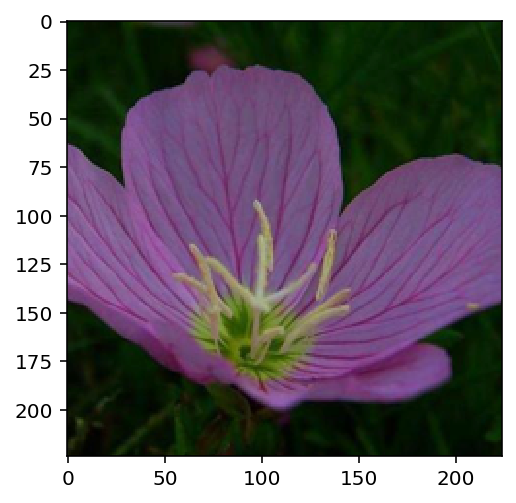

In [25]:
image_path = 'test/1/image_06752.jpg'
img = process_image(image_path)
imshow(img)

#Class Prediction
OnceI have got images in the correct format, I have written a function for making predictions with my model. A common practice is to predict the top 5 or so (usually called top- K ) most probable classes. I have calculated the class probabilities then find the  K  largest values.

To get the top  K  largest values in a tensor I have used x.topk(k). This method returns both the highest k probabilities and the indices of those probabilities corresponding to the classes. I have converted these indices to image names using class_names got from cat_to_name.json



In [0]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(Variable(model_input.cuda())))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs, top_labs =top_probs.data, top_labs.data
    top_probs = top_probs.cpu().numpy().tolist()[0] 
    top_labs = top_labs.cpu().numpy().tolist()[0]
    #print(top_labs)
    # Convert indices to classes
    '''idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]'''
    top_flowers = [class_names[lab] for lab in top_labs]
    return top_probs, top_flowers

#Sanity Checking
Now I have used a trained model for predictions. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. I have used matplotlib to plot the probabilities for the top 5 classes as a bar graph, along with the input image. 


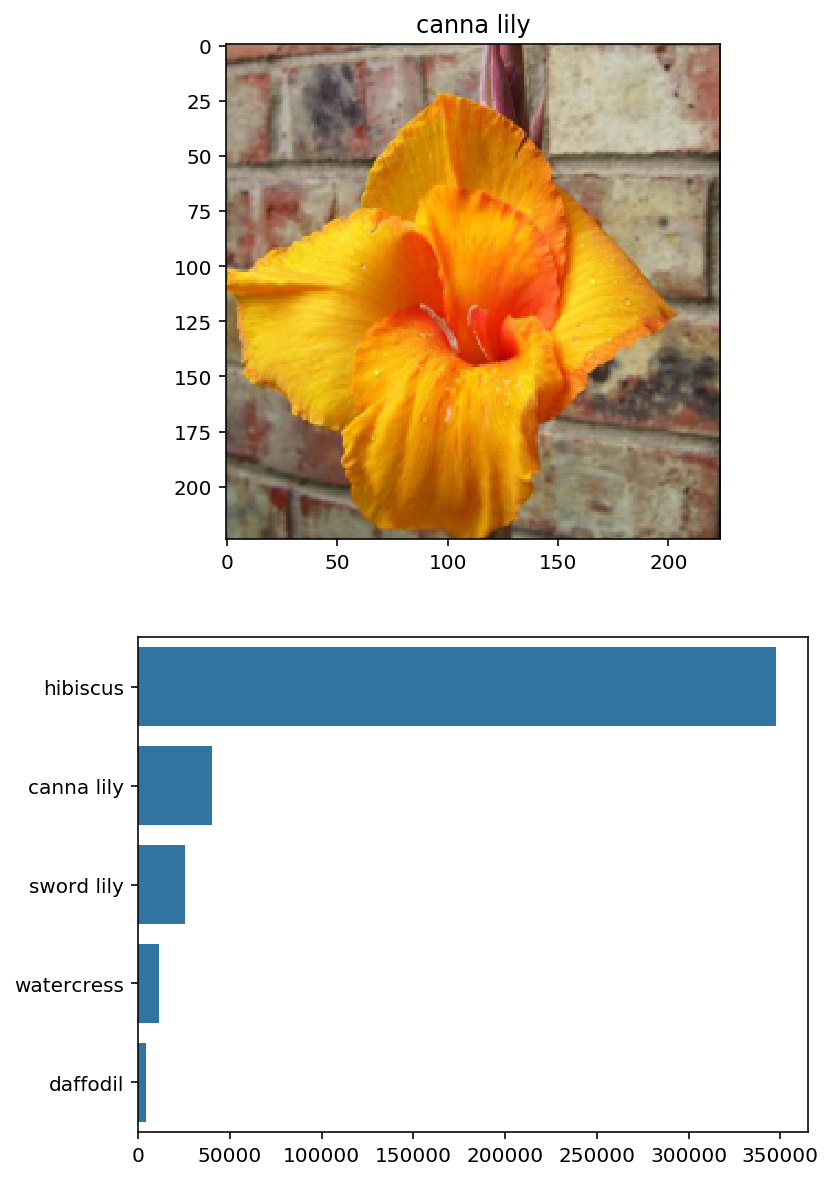

In [27]:
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    flower_num = image_path.split('/')[1]
    title_ = cat_to_name[flower_num]
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make prediction
    probs, flowers = predict(image_path, model) 
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()
image_path = 'test/90/image_04432.jpg'
plot_solution(image_path, model_ft)